In [2]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [3]:
data = pd.read_excel('HeatExchanger_Data.xlsx').values
data = data[:, 1:]
mfg = data[:, 0]
msteam = data[:, 1]
Tfgin = data[:, 2]
Tsteamin = data[:, 3]
Tfgout = data[:, 4]
Tsteamout = data[:, 5]
Ttube = data[:, 6]
tt = data.shape[0]  # Total data
tn = int(0.6 * tt)  # Total Number of Training Data
tv = tt - tn  # Total Number of Validation Data
nt = 7  # Total number of variables
ni = 4  # Number of neurons in Input Layer
no = 3  # Number of neurons in Output Layer

In [4]:
norm_mat = np.zeros((tt, nt))
delta = np.zeros(nt)
for i in range(nt):
    delta[i] = np.max(data[:, i]) - np.min(data[:, i])
    norm_mat[:, i] = (data[:, i] - np.min(data[:, i])) / delta[i]  # Max-Min Normalization
    
dsr = norm_mat[:, 4:7].T  # Target array
Imat = np.concatenate((norm_mat[:, 2:4], norm_mat[:, 0:2]), axis=1).T  # Input array

tr_steps = np.random.choice(tt, tn, replace=False)
tr_steps = np.sort(tr_steps)
dsr_t = np.zeros((no, tn))
Imat_t = np.zeros((ni, tn))
for i in range(tn):
    ts = tr_steps[i]
    dsr_t[:, i] = dsr[:, ts]          # Training Output: dsr_t 
    Imat_t[:, i] = Imat[:, ts]        # Training Input: Imat_t 

val_steps = np.setdiff1d(np.arange(tt), tr_steps)
dsr_v = np.zeros((no, tv))
Imat_v = np.zeros((ni, tv))

for i in range(tv):
    ts = val_steps[i]
    dsr_v[:, i] = dsr[:, ts]
    Imat_v[:, i] = Imat[:, ts]  

In [5]:
Imat.shape[0]

4

In [6]:
AIC_values = np.zeros(100)
sum_square_err_values = np.zeros(100)
for tc in range(1,101):  #100 centres
    number_of_centres=tc
    # Getting coordinates of the centres
    distances = np.zeros(len(Imat_t[1]))
    mean1=np.mean(Imat_t[:,0])
    mean2=np.mean(Imat_t[:,1])
    mean3=np.mean(Imat_t[:,2])
    mean4=np.mean(Imat_t[:,3])
    mean = np.array([mean1, mean2, mean3, mean4])
    for i in range(len(Imat_t)):
        for j in range(ni):
            distances[i]+=Imat_t[j][i]-mean[j]
    indices = np.argsort(distances)   # Sorting the distances and get corresponding indices
    # for l in range(tc):
    #     centermat=Imat_t[indices[l]]
    centermat = Imat_t[:,indices[:tc]]   # Select 'tc'-nearest neighbors as the centres

    #Getting width
    #sigma = 2
    kmeans = KMeans(n_clusters=tc)
    kmeans.fit(Imat_t.T)
    centers = kmeans.cluster_centers_.T
    sigma = np.mean(np.linalg.norm(centermat - centers, axis=0))

    #Getting Weights by Least Square method
    D = np.zeros((tc, tn))
    for i in range(tc):
        for j in range(tn):
            D[i, j] = np.linalg.norm(centermat[:, i] - Imat_t[:, j])
    PhiofD = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-D**2 / (2 * sigma**2))  
    z = np.linalg.pinv(PhiofD.T) @ dsr_t.T
    D = np.zeros((tc, tn))
    for i in range(tc):
        for j in range(tn):
            D[i, j] = np.linalg.norm(centermat[:, i] - Imat_t[:, j])
    yHL = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-D**2 / (2 * sigma**2))
    ynn_tv = np.dot(yHL.T, z)  # Prediction of Training Data
    dsr_t_v = dsr_t.T*delta[ni:] + np.min(data[:, ni:], axis=0)
    ynn_t_v = ynn_tv*delta[ni:] + np.min(data[:, ni:], axis=0)

    num_parameters = number_of_centres*dsr.shape[0]
    element_wise_square_of_error = np.square((dsr_t_v-ynn_t_v))
    sum_square_err= np.sum(element_wise_square_of_error)
    log_likelihood= -0.5*dsr.shape[1]*dsr.shape[0]*np.log(2*np.pi) -0.5*((sum_square_err)/(dsr.shape[1]*dsr.shape[0]))
    #log_likelihood= -0.5*dsr.shape[1]*Imat.shape[0]*np.log(2*np.pi*(sigma)**2) -0.5*((sum_square_err)/(sigma**2))
    #AIC = -2*log_likelihood + 2*num_parameters + ((2*num_parameters*(num_parameters+1))/(Imat.shape[0]-num_parameters-1))
    AIC = -2*log_likelihood + 2*num_parameters  + ((2*num_parameters*(num_parameters+1))/(dsr.shape[1]-num_parameters-1))
    AIC_values[tc-1] = AIC 
    sum_square_err_values[tc-1] = sum_square_err

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

In [7]:
minimum_AIC = np.argmin(AIC_values)
print("MIN AIC FOR TEST_X:", minimum_AIC+1)  

MIN AIC FOR TEST_X: 4


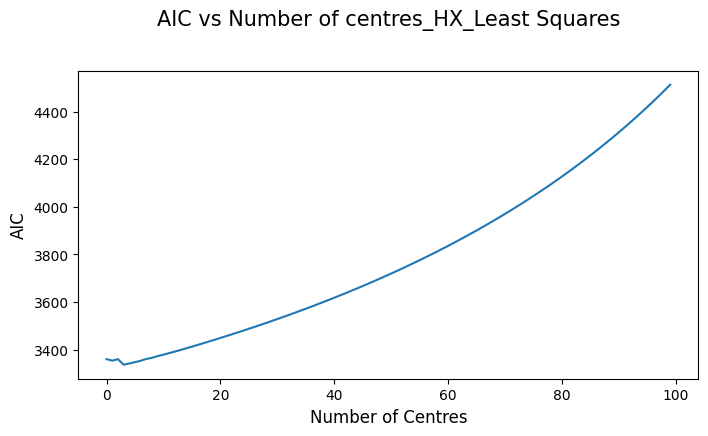

In [8]:
plt.figure(figsize=(8, 4))
plt.title("AIC vs Number of centres_HX_Least Squares", fontsize=15 ,y=1.12)
plt.xlabel('Number of Centres', fontsize=12)
plt.ylabel('AIC', fontsize=12)
plt.plot(AIC_values)
plt.show()

In [9]:
minimum_MSE = np.argmin(sum_square_err_values)
print("MIN MSE FOR TEST_X:", minimum_MSE+1)  

MIN MSE FOR TEST_X: 99


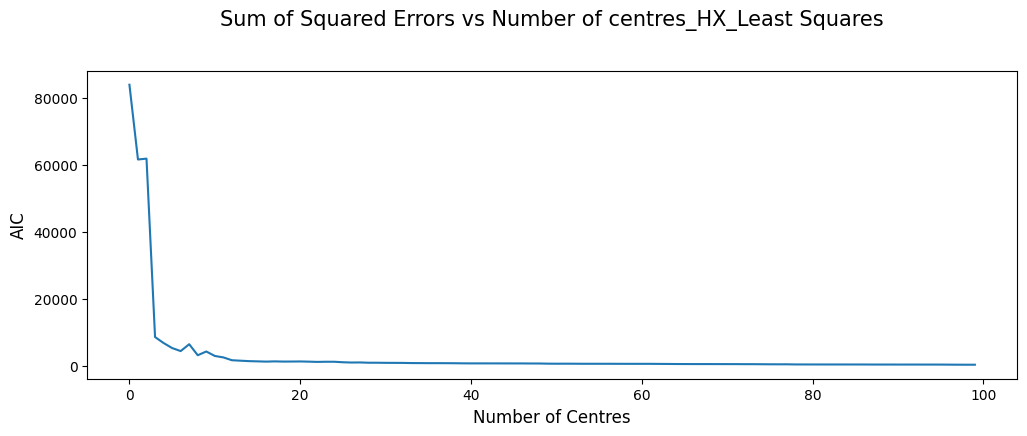

In [10]:
plt.figure(figsize=(12, 4))
plt.title("Sum of Squared Errors vs Number of centres_HX_Least Squares", fontsize=15 ,y=1.12)
plt.xlabel('Number of Centres', fontsize=12)
plt.ylabel('AIC', fontsize=12)
plt.plot(sum_square_err_values)
plt.show()